In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

filename = "../L-L1_GWOSC_16KHZ_R1-1266618157-32.hdf5"

with h5py.File(filename, "r") as f:
    strain_data = f["strain/Strain"][:]

In [2]:
CHUNK_SIZE = 1024
FS = 16384
fft_chunk = []

# splitting the data into 1024-element chunks and putting them into FFT to generate a raw spectrogram
for s in range(0, len(strain_data)-CHUNK_SIZE, CHUNK_SIZE//2):
    chunk = strain_data[s:s+CHUNK_SIZE] * np.hanning(CHUNK_SIZE)
    
    fft_chunk.append(10 * np.log10(np.abs(np.fft.rfft(chunk))))

spectro_data = np.array(fft_chunk).T

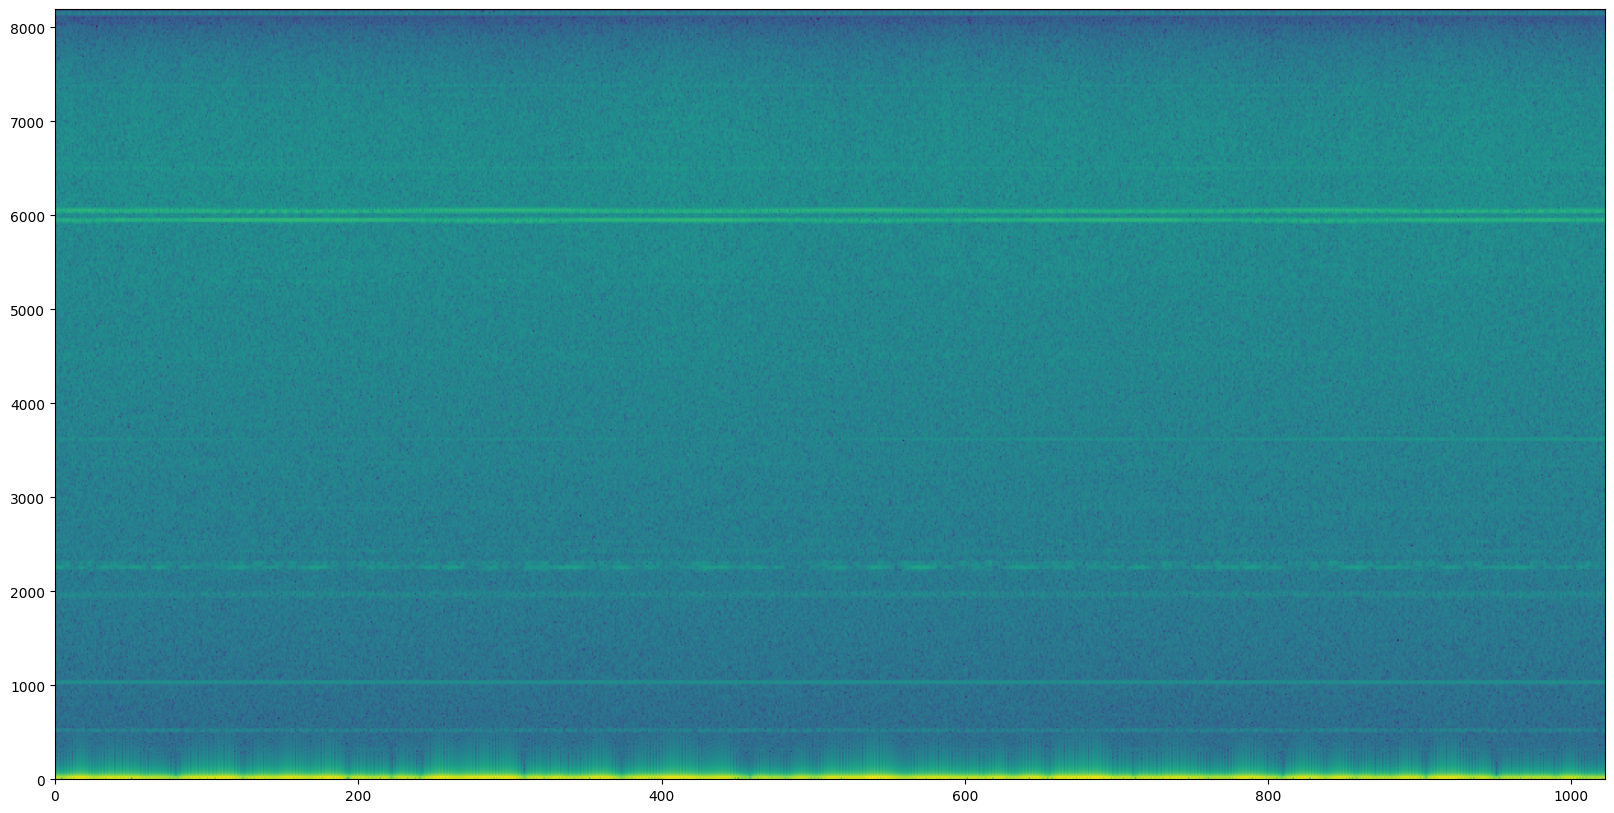

In [3]:
plt.figure(figsize=(20,10))
plt.imshow(spectro_data, 
           extent=(0,spectro_data.shape[1],0,FS//2), 
           aspect="auto",
          origin="lower")

In [4]:
spectro_data.shape

(513, 1022)

In [ ]:
# The spectrogram doesnt show anything no matter what i do with it.
# Recently learned about the constant Q transform, going to try that

In [29]:
BPO = 12
# bins per octave - a standard 12 that appears in most papers
Q = 1 / (2 ** (1 / BPO) - 1)
# the q factor, ratio between frequencies - constant as the name implies
min_freq = 10
max_freq = 1000
bin_num = np.ceil(BPO * np.log2(max_freq / min_freq))
# as many bins as powers of 2^1/12 between min and max frequency

freqs_logscale = min_freq * 2 ** (np.arange(bin_num) / BPO)

convolution_1 = np.fft.fft(strain_data, n = len(strain_data) * 2)
# multiplying two ffts and inverting the fft back is a convolution

In [30]:
const_q = []

for i, freq in enumerate(freqs_logscale):
    wavelet_len = np.ceil(Q * FS / freq)
    wavelet_time = (np.arange(wavelet_len) - wavelet_len // 2) / FS
    
    wavelet = np.hanning(wavelet_len) * np.exp(2j * np.pi * freq * wavelet_time)
    convolution_2 = np.fft.fft(wavelet, n = len(strain_data) * 2)
    
    const_q.append(np.abs(np.fft.ifft(convolution_1 * convolution_2))[:len(strain_data)])
    

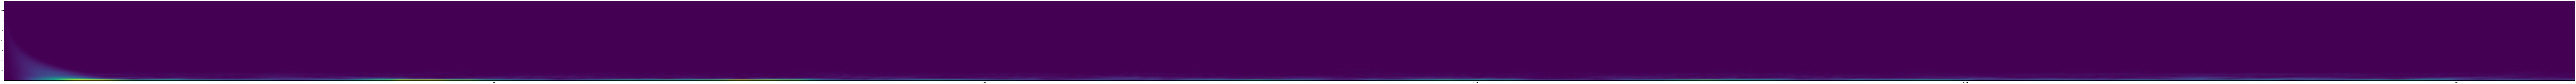

In [31]:
plt.figure(figsize=(320,10))
plt.imshow(const_q, 
           aspect="auto",
          origin="lower")